# Capstone Project - The Battle of the Neighborhoods, Building Live Music Venues in Toronto

## Table of contents
* #### Introduction: Business Problem
* #### Data Source
* #### Study Feature Venues Surrounding Famous Live Music Venues
* #### Suggest Potential Borough and the Type of Live Music Venues to build in Toronto 

## 1. Introduction: Business Problem 

Music has played a substantial role in human’s life. It is tightly connected to the course of human history; a man sings a love song to his lover, mother hums melody to comfort her baby, and the history of a race can be passed down through music. From the creative music blog, it is stated that music makes us creative, makes us express our emotion, and makes learning more pleasant. As the most populous city in Canada and the fourth most populous city in North America, the establishment of more live music venues can further decorate and upgrade the historical and diverse city of Toronto. This can provide valuable information to the Toronto officials and investors. 

To achieve the goal, we use data science techniques to suggest the potential borough and the type of live music venues to build in Toronto. Based on the analysis of nearby venues of the best live music venues via exploratory data Analysis and clustering, we investigate the kinds of venues (feature venues) that sustain their continual success. The cluster analysis will then be used to reveal the areas of Toronto that shares comparable surrounding feature venues of the model live music venues. Upon looking into the clusters, boroughs of Toronto that have potential to sustain a successful live music venue can be revealed. 

In summary, to make Toronto an even popular city via the establishment of live music venues, the questions below will be answered through data science techniques:
1. What are the kinds of venues surrounding the best live music venues?
2. What are area in Toronto should the live music venues be invested upon? 


## 2. Data Source

Based on definition of our problem, the following data are needed. 

1.The Best Live Music Avenves are needed for analysis.
This piece of information are obtaned from the ROLLING STONE magazine and musicgateway website.The latitudes and longitudes for each best live music venue can be obtained from latitude website.   

* ROLLING STONE:10 Best Live Music Venues in America <br>
  https://www.rollingstone.com/music/music-lists/10-best-live-music-venues-in-america-767070/ottobar-baltimore-767244/
 
* musicgateway: The 10 Best Live Music Venues In The US – NYC To San Francisco & More <br>
  https://www.musicgateway.com/blog/how-to/best-live-music-venues-in-the-us
* latitude <br>
  https://latitude.to/articles-by-country/us/united-states/

2.The borough infomration of Toronto is scrape off the following Wikipedia page using BeautifulSoup, and the corresponding Coordinate data is obtained link listed below.

* borough infomration <br>
  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 

* Coordinate data <br>
  http://cocl.us/Geospatial_data

3.The venues data associated with a geographic coordinate is obtained from Foursquare API, in which Venue's name, latitude, longitude, and Category will be given within a specified radius (meter) from the given coordinates.     

### Import Liberary

In [5]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')
print('Your baby is here')

Libraries imported.
Your baby is here


In [2]:
#!pip install bs4
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from urllib.request import urlopen
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

## 3. Study Feature Venues Surrounding Famous Live Music Venues

Load the Top 6 best Live Music Venues suggested by the Rolling Stone and musicgateway, links mentioned in the Data Source section. Then, we visualize them on the map using folium. As can be seen below, these best Live Music Venues are scattered accross the USA.

In [3]:
LMV_data=pd.read_csv('TopMusicVenuesUSA.csv')
LMV_data

,Name,Location,Latitude,Longitude
0,Red Rocks,Colorado,39.66650,-105.20750
1,Hollywood Bowl,Los Angeles,34.11220,-118.33670
2,Brooklyn Steel,New York City,40.70570,-73.99640
3,Ryman Auditorium,Nashville,36.16120,-86.77840
4,9:30 Club,"Washington, D.C.",38.91800,-77.02370
5,First Ave,Minneapolis,44.97800,-93.27590
6,Tower Theater,Philadelphia,39.95258,-75.16522
7,El Club,Detroit,42.33143,-83.04575
8,Stubbs,Austin,30.26667,-97.73333
9,The Fillmore,San Francisco,37.78410,-122.43313


In [4]:
address = 'USA'
geolocator = Nominatim(user_agent="USA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

map_USA = folium.Map(location=[latitude, longitude], zoom_start=4.4)

# add markers to map
for lat, lng, name, loca in zip(LMV_data['Latitude'], LMV_data['Longitude'], LMV_data['Name'], LMV_data['Location']):
    label = '{}, {}'.format(name, loca)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_USA)  
    
map_USA



The geograpical coordinate of USA are 39.7837304, -100.4458825.


### 3.1 Explore Venues in Neighborhoods via Foursquare for data analysis

In [5]:
CLIENT_ID = 'FLWBHKCLQQQRIJA3XKLJELTZO3ZDRCZ3VQ1SDFLLQGMOXD5H' # your Foursquare ID
CLIENT_SECRET = 'ADW121EHUO10CJGRHTJIUJH3OLHD0YTB2LE25Z41K2IIOYU1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FLWBHKCLQQQRIJA3XKLJELTZO3ZDRCZ3VQ1SDFLLQGMOXD5H
CLIENT_SECRET:ADW121EHUO10CJGRHTJIUJH3OLHD0YTB2LE25Z41K2IIOYU1


In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Best Music Venue', 
                  'MV Latitude', 
                  'MV Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
LMV_venues = getNearbyVenues(names=LMV_data['Name'],
                                   latitudes=LMV_data['Latitude'],
                                   longitudes=LMV_data['Longitude']
                                  )

Red Rocks
Hollywood Bowl
Brooklyn Steel
Ryman Auditorium
9:30 Club
First Ave
Tower Theater
El Club
Stubbs
The Fillmore
The Tabernacle
The Norva
Jay Pritzker Pavilion


In [8]:
print(LMV_venues.shape)
LMV_venues.head()

(1239, 7)


,Best Music Venue,MV Latitude,MV Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Red Rocks,39.6665,-105.2075,Red Rocks Park & Amphitheatre,39.665380,-105.205861,Amphitheater
1,Red Rocks,39.6665,-105.2075,Red Rocks Trading Post,39.663954,-105.203058,Gift Shop
2,Red Rocks,39.6665,-105.2075,Trading Post Trail,39.663916,-105.202641,Trail
3,Red Rocks,39.6665,-105.2075,Film on the Rocks,39.665482,-105.205618,Concert Hall
4,Red Rocks,39.6665,-105.2075,Red Rocks Hiking Path,39.672227,-105.204623,Trail


In [9]:
#LMV_venues.groupby(['Model Venue']).count()
print('{} nearby venue for each Model venue.'.format(LMV_venues.groupby(['Best Music Venue']).count().iloc[0,0]))

100 nearby venue for each Model venue.


### 3.2 Investigate Feature Venues Nearby the Best Live Music Venues

After we have the venue information nearby the best Live Music Venues, we then go on to analyze the main kinds of venues (feature venue) in the neighborhood of the best Live Music Venues. In other words, this is to know what are the venues that support Best Live Music Venues. To achieve it, we first use one hot coding to list the nearby venues of the Best Live Music venue, followed by using the "mean" of surrounding venues as the representative venues associated with each Best Live Music venues. We then use the bar chart to show the Top 10 venue category. From the cluster analysis, it can be seen that some Live Music venues are located in urban and some in suburban areas,therefore, feature venues are investigated further for each case using bar chart and scatter plot.        

###  3.2.1 Exploratory Data Analysis

####  One Hot encoding to transform the collected nearby Venues 

In [10]:
LMV_venues_onehot = pd.get_dummies(LMV_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LMV_venues_onehot['Best Music Venue'] = LMV_venues['Best Music Venue'] 

# move neighborhood column to the first column
fixed_columns = [LMV_venues_onehot.columns[-1]] + list(LMV_venues_onehot.columns[:-1])
LMV_venues_onehot = LMV_venues_onehot[fixed_columns]

print(LMV_venues_onehot.shape)
LMV_venues_onehot.head()

(1239, 237)


,Best Music Venue,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Capitol Building,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Driving School,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Heliport,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Reservoir,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Red Rocks,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Red Rocks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### "Mean" to represent the feature venues associated with each Best Live Music Venue

In [11]:
LMV_venues_onehot_grouped = LMV_venues_onehot.groupby('Best Music Venue').mean().reset_index()
print(LMV_venues_onehot_grouped.shape)
LMV_venues_onehot_grouped

(13, 237)


,Best Music Venue,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Capitol Building,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Driving School,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Heliport,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Reservoir,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,9:30 Club,0.040000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.02,0.00,0.030000,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,0.01,0.00,0.00,0.00,0.01,0.000000,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.04,0.07,0.00,0.00,0.00,0.00,0.020000,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.000000,0.00,0.01,0.03,0.02,0.020000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

#### Top Feature Venues Nearby the Best Live Music Venues

Text(0, 0.5, 'Weight')

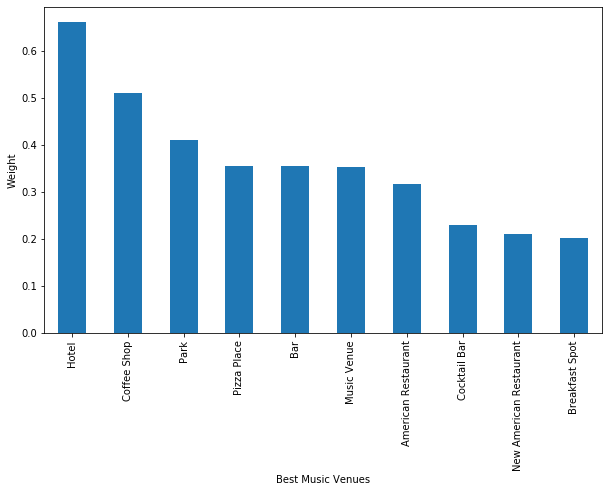

In [12]:
FeatureNBV=LMV_venues_onehot_grouped.iloc[:,1:-1].sum(axis=0).to_frame().sort_values(by=[0],ascending = False)
FeatureNBV.rename(columns = {0:'Weight' }, inplace = True)

FeatureNBV.iloc[0:10,0].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Best Music Venues')
plt.ylabel('Weight')

### 3.2.2 Cluster Analysis

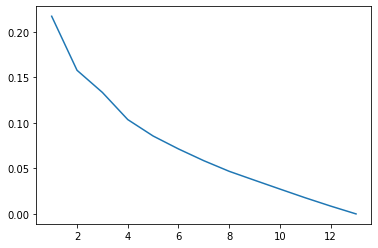

In [13]:
# set number of clusters
#since some top music venue lies in subburbun and some in city, that's doing cluster anaylysis and then see the feature in each cluster.
inertia=[]
kclusters=LMV_data.shape[0]
for kk in range(1,kclusters+1):
    LMV_venues_onehot_grouped_clustering = LMV_venues_onehot_grouped.drop('Best Music Venue', 1)
    kmeans = KMeans(n_clusters=kk, random_state=0).fit(LMV_venues_onehot_grouped_clustering)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1,kclusters+1), inertia)

In [50]:
kclusters=4
LMV_venues_onehot_grouped_clustering = LMV_venues_onehot_grouped.drop('Best Music Venue', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(LMV_venues_onehot_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

LMV_venues_onehot_grouped['Cluster']=kmeans.labels_
Final=LMV_venues_onehot_grouped[['Best Music Venue','Cluster']]

disCen=[]
for SMV in LMV_venues_onehot_grouped['Best Music Venue']:
    SelecMV=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV)]
    disCen.append(sum(np.sqrt((SelecMV['MV Latitude']-SelecMV['Venue Latitude'])**2 + (SelecMV['MV Longitude']-SelecMV['Venue Longitude'])**2))/SelecMV.shape[0])
    
Final['D']=disCen
Final

[0 1 0 1 1 1 2 3 0 1 1 1 1]


C:\Users\jovis\PyMOL\envs\Py3-TF2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Best Music Venue,Cluster,D
0,9:30 Club,0,0.008534
1,Brooklyn Steel,1,0.010298
2,El Club,0,0.006663
3,First Ave,1,0.007210
4,Hollywood Bowl,1,0.012992
5,Jay Pritzker Pavilion,1,0.009812
6,Red Rocks,2,0.011063
7,Ryman Auditorium,3,0.004545
8,Stubbs,0,0.008302
9,The Fillmore,1,0.008604


#### Analysis of Cluster 0
* #### Top Surrounding Feature Veneues 

# of LMV in this cluster 3


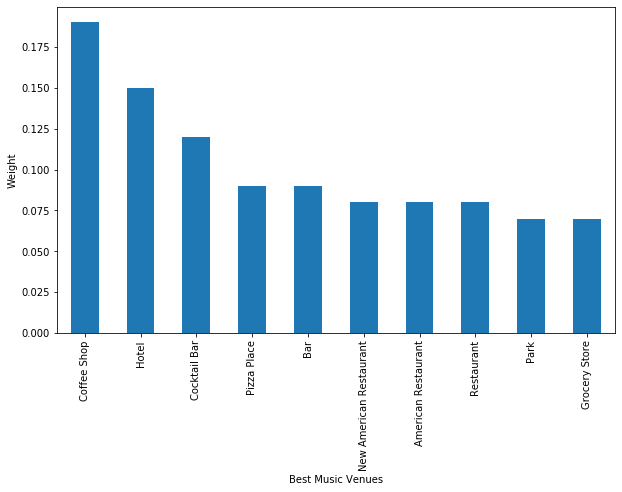

In [56]:
CLUSTER=0
Name="C"+str(CLUSTER)
Name=LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].iloc[:,1:-1].sum(axis=0).to_frame().sort_values(by=[0],ascending = False)
Name.rename(columns = {0:'Weight' }, inplace = True)

Name.iloc[0:10,0].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Best Music Venues')
plt.ylabel('Weight')

print("# of LMV in this cluster {}".format(LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].shape[0]))

* #### Venues Distribution

Text(0, 0, 'x')

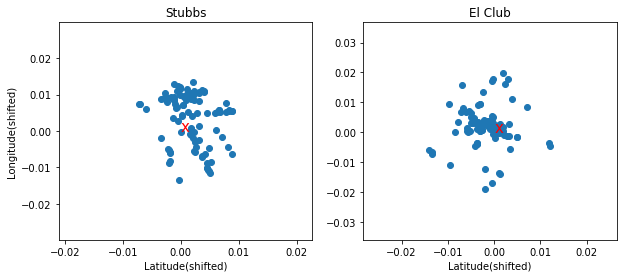

In [57]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))

SMV0='Stubbs'
SelecMV0=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV0)]
ax[0].scatter((SelecMV0['MV Latitude']-SelecMV0['Venue Latitude']),(SelecMV0['MV Longitude']-SelecMV0['Venue Longitude'])) 
ax[0].set_xlabel('Latitude(shifted)')
ax[0].set_ylabel('Longitude(shifted)')
ax[0].set_title(SMV0)
ax[0].text(0,0,'x',fontsize=15,color='red')

SMV1='El Club'
SelecMV1=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV1)]
ax[1].scatter((SelecMV1['MV Latitude']-SelecMV1['Venue Latitude']),(SelecMV1['MV Longitude']-SelecMV1['Venue Longitude'])) 
ax[1].set_xlabel('Latitude(shifted)')
#ax[1].set_ylabel('Longitude(shifted)')
ax[1].set_title(SMV1)
ax[1].text(0,0,'x',fontsize=15,color='red')



#### Analysis of Cluster 1
* #### Top Surrounding Feature Veneues 

# of LMV in this cluster 8


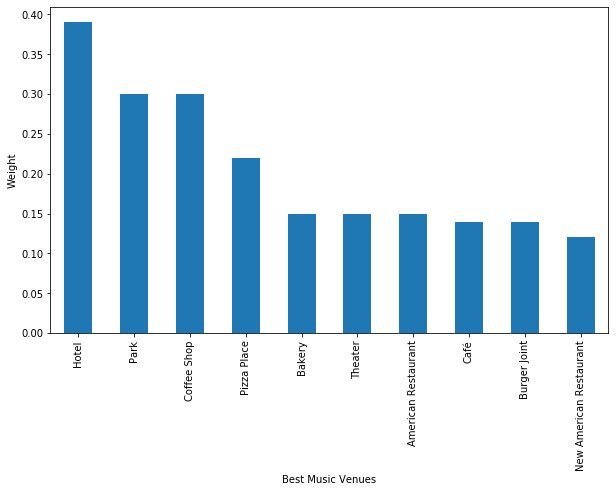

In [58]:
CLUSTER=1
Name="C"+str(CLUSTER)
Name=LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].iloc[:,1:-1].sum(axis=0).to_frame().sort_values(by=[0],ascending = False)
Name.rename(columns = {0:'Weight' }, inplace = True)

Name.iloc[0:10,0].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Best Music Venues')
plt.ylabel('Weight')

print("# of LMV in this cluster {}".format(LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].shape[0]))

* #### Venues Distribution

Text(0, 0, 'x')

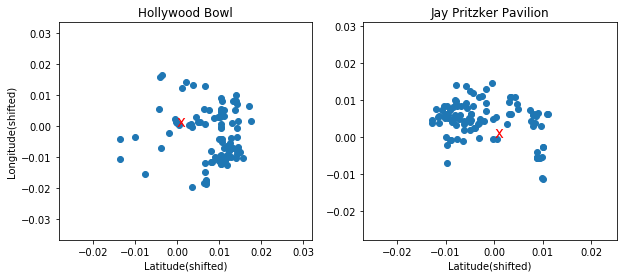

In [59]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))

SMV0='Hollywood Bowl'
SelecMV0=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV0)]
ax[0].scatter((SelecMV0['MV Latitude']-SelecMV0['Venue Latitude']),(SelecMV0['MV Longitude']-SelecMV0['Venue Longitude'])) 
ax[0].set_xlabel('Latitude(shifted)')
ax[0].set_ylabel('Longitude(shifted)')
ax[0].set_title(SMV0)
ax[0].text(0,0,'x',fontsize=15,color='red')

SMV1='Jay Pritzker Pavilion'
SelecMV1=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV1)]
ax[1].scatter((SelecMV1['MV Latitude']-SelecMV1['Venue Latitude']),(SelecMV1['MV Longitude']-SelecMV1['Venue Longitude'])) 
ax[1].set_xlabel('Latitude(shifted)')
#ax[1].set_ylabel('Longitude(shifted)')
ax[1].set_title(SMV1)
ax[1].text(0,0,'x',fontsize=15,color='red')

#SMV2='The Tabernacle'
#SelecMV2=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV2)]
#ax[2].scatter((SelecMV2['MV Latitude']-SelecMV2['Venue Latitude']),(SelecMV2['MV Longitude']-SelecMV2['Venue Longitude'])) 
#ax[2].set_xlabel('Latitude(shifted)')
#ax[2].set_ylabel('Longitude(shifted)')
#ax[2].set_title(SMV2)
#ax[2].text(0,0,'x',fontsize=15,color='red')

#fig.savefig("foo.png", bbox_inches='tight', dpi=600)

#### Analysis of Cluster 2
* #### Top Surrounding Feature Veneues 

# of LMV in this cluster 1


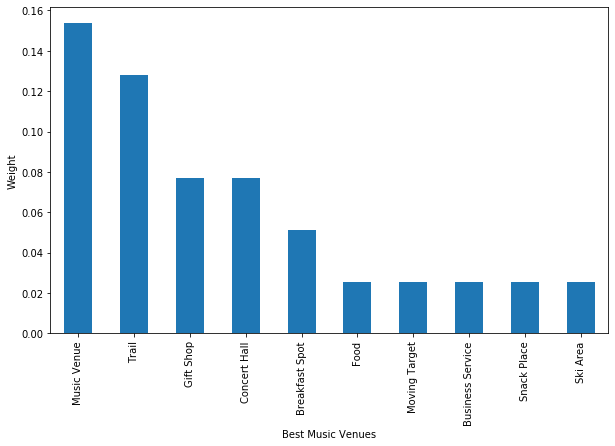

In [60]:
CLUSTER=2
Name="C"+str(CLUSTER)
Name=LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].iloc[:,1:-1].sum(axis=0).to_frame().sort_values(by=[0],ascending = False)
Name.rename(columns = {0:'Weight' }, inplace = True)

Name.iloc[0:10,0].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Best Music Venues')
plt.ylabel('Weight')

print("# of LMV in this cluster {}".format(LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].shape[0]))

plt.savefig("foo.png", bbox_inches='tight', dpi=600)

Text(0, 0, 'x')

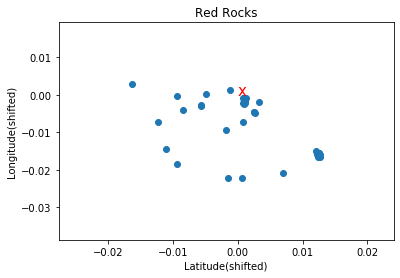

In [61]:
SMV='Red Rocks'
SelecMV=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV)]
plt.scatter((SelecMV['MV Latitude']-SelecMV['Venue Latitude']),(SelecMV['MV Longitude']-SelecMV['Venue Longitude'])) 
plt.xlabel('Latitude(shifted)')
plt.ylabel('Longitude(shifted)')
plt.title(SMV)
plt.text(0,0,'x',fontsize=15,color='red')

#### Analysis of Cluster 3
* #### Top Surrounding Feature Veneues 

# of LMV in this cluster 1


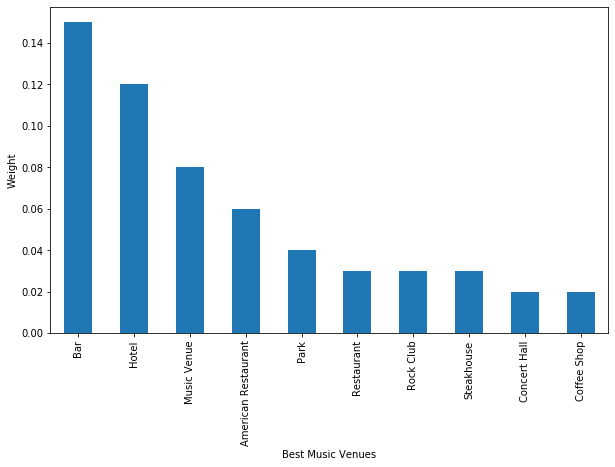

In [62]:
CLUSTER=3
Name="C"+str(CLUSTER)
Name=LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].iloc[:,1:-1].sum(axis=0).to_frame().sort_values(by=[0],ascending = False)
Name.rename(columns = {0:'Weight' }, inplace = True)

Name.iloc[0:10,0].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Best Music Venues')
plt.ylabel('Weight')

print("# of LMV in this cluster {}".format(LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].shape[0]))

Text(0, 0, 'x')

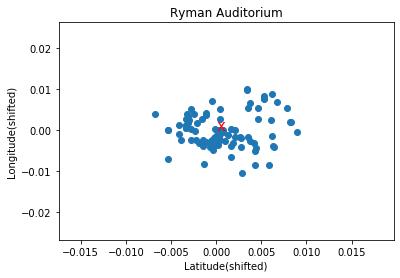

In [64]:
SMV='Ryman Auditorium'
SelecMV=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV)]
plt.scatter((SelecMV['MV Latitude']-SelecMV['Venue Latitude']),(SelecMV['MV Longitude']-SelecMV['Venue Longitude'])) 
plt.xlabel('Latitude(shifted)')
plt.ylabel('Longitude(shifted)')
plt.title(SMV)
plt.text(0,0,'x',fontsize=15,color='red')

## 4. Suggest Potential Borough and the Type of Live Music Venues to build in Toronto 

### 4.1 Collect the Infomation related to Toronto via Website Scraping 

In [24]:
# use the 'find_all' function to bring back all wikitable 
all_tables=soup.find_all("table", class_='wikitable sortable')
print('Number of tables in the website =', len(all_tables))

TGTTable=all_tables[0]
print('Number of rows (including header) in the table =',len(TGTTable.findAll('tr')))

Number of tables in the website = 1
Number of rows (including header) in the table = 181


In [25]:
#Loop through the rows and columns to get the data
A=[]
B=[]
C=[]

for row in TGTTable.findAll('tr'):
    col=row.findAll('td')
    if len(col)==3:       #exclude header
        A.append(col[0].find(text=True).strip())  #strip() is to remove \n in the extracted text
        B.append(col[1].find(text=True).strip())
        C.append(col[2].find(text=True).strip())

df=pd.DataFrame(A,columns=['Postal Code'])
df['Borough']=B
df['Neighbourhood']=C
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [26]:
df1=df[~df['Borough'].isin(["Not assigned"])]
No1=(df1['Neighbourhood']=='Not assigned').value_counts()

DF_Cleaned=df1.reset_index(drop=True)
print(DF_Cleaned.shape)
DF_Cleaned.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [27]:
ToGeo_DF=pd.read_csv('Geospatial_Coordinates.csv')
print(ToGeo_DF.shape)

ToGeo_DF=pd.merge(DF_Cleaned,ToGeo_DF, left_on="Postal Code", right_on="Postal Code")
ToGeo_DF.drop(['Postal Code','Neighbourhood'], axis=1, inplace=True)
ToGeo_DF.head()

(103, 3)


,Borough,Latitude,Longitude
0,North York,43.753259,-79.329656
1,North York,43.725882,-79.315572
2,Downtown Toronto,43.654260,-79.360636
3,North York,43.718518,-79.464763
4,Downtown Toronto,43.662301,-79.389494


According to the website https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto
, there are six main Boroughs in Toronto, Old Toronto, East York, Etobicoke, North York, Scarborough, and York. Therefore, lets group the data into these releams.

In [28]:
ToGeo_DF['Borough'][ToGeo_DF['Borough'].str.contains("Toronto")]="Old Toronto"
ToGeo_DF.head()

C:\Users\jovis\PyMOL\envs\Py3-TF2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Borough,Latitude,Longitude
0,North York,43.753259,-79.329656
1,North York,43.725882,-79.315572
2,Old Toronto,43.654260,-79.360636
3,North York,43.718518,-79.464763
4,Old Toronto,43.662301,-79.389494


Visualize

In [29]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(ToGeo_DF['Latitude'], ToGeo_DF['Longitude'], ToGeo_DF['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### 4.2 Explore Venues in Neighborhoods via Foursquare for Data Analysis

In [30]:
# type your answer here, results from foursquare
Toronto_venues = getNearbyVenues(names=ToGeo_DF['Borough'],
                                   latitudes=ToGeo_DF['Latitude'],
                                   longitudes=ToGeo_DF['Longitude']
                                  )

North York
North York
Old Toronto
North York
Old Toronto
Etobicoke
Scarborough
North York
East York
Old Toronto
North York
Etobicoke
Scarborough
North York
East York
Old Toronto
York
Etobicoke
Scarborough
Old Toronto
Old Toronto
York
Scarborough
East York
Old Toronto
Old Toronto
Scarborough
North York
North York
East York
Old Toronto
Old Toronto
Scarborough
North York
North York
East York
Old Toronto
Old Toronto
Scarborough
North York
North York
Old Toronto
Old Toronto
Old Toronto
Scarborough
North York
North York
Old Toronto
Old Toronto
North York
North York
Scarborough
North York
North York
Old Toronto
North York
York
North York
Scarborough
North York
North York
Old Toronto
Old Toronto
York
York
Scarborough
North York
Old Toronto
Old Toronto
Old Toronto
Etobicoke
Scarborough
North York
Old Toronto
Old Toronto
Old Toronto
Mississauga
Etobicoke
Scarborough
Old Toronto
Old Toronto
Old Toronto
Scarborough
Old Toronto
Old Toronto
Scarborough
Old Toronto
Old Toronto
Etobicoke
Etobicoke
Sca

### 4.3 Data Transformation for Analysis 

#### Analyze neighborhood of each main boroughs in Toronto

In [31]:
#Add together the venues
Total_venues=Toronto_venues.append(LMV_venues, ignore_index = True)
Total_venues.rename(columns = {'Best Music Venue':'Name', 'MV Latitude':'Latitude','MV Longitude':'Longitude' }, inplace = True)
print(Toronto_venues.shape)
print(Total_venues.shape)
Total_venues.head()

(8681, 7)
(9920, 7)


,Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,North York,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,North York,43.753259,-79.329656,Galleria Supermarket,43.753520,-79.349518,Supermarket
3,North York,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
4,North York,43.753259,-79.329656,Graydon Hall Manor,43.763923,-79.342961,Event Space


In [32]:
# one hot encoding
Total_onehot = pd.get_dummies(Total_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Total_onehot['Name'] = Total_venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [Total_onehot.columns[-1]] + list(Total_onehot.columns[:-1])
Total_onehot = Total_onehot[fixed_columns]

print(Total_onehot.shape)
Total_onehot.head()

(9920, 382)


,Name,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Driving School,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pide Place,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool

#### Mean to represent the neighbourhood of each top live music venue

In [33]:
Total_onehot_grouped = Total_onehot.groupby('Name').mean().reset_index()
Total_onehot_grouped=Total_onehot_grouped[~Total_onehot_grouped.Name.str.match('Mississauga*')].reset_index(drop=True)
print(Total_onehot_grouped.shape)
Total_onehot_grouped.head()

(19, 382)


,Name,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Driving School,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pide Place,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool

### 4.4 Cluster Analysis

In [34]:
kclusters=4
Total_onehot_grouped_clustering = Total_onehot_grouped.drop('Name', 1)
kmeans = KMeans(n_clusters=kclusters).fit(Total_onehot_grouped_clustering)
print(kmeans.labels_)

Total_onehot_grouped['Cluster']=kmeans.labels_
Final=Total_onehot_grouped[['Name','Cluster']]
Final

[1 1 1 3 1 3 3 3 1 1 2 0 1 3 1 3 3 3 1]


,Name,Cluster
0,9:30 Club,1
1,Brooklyn Steel,1
2,East York,1
3,El Club,3
4,Etobicoke,1
5,First Ave,3
6,Hollywood Bowl,3
7,Jay Pritzker Pavilion,3
8,North York,1
9,Old Toronto,1


#### Potential borough and live music venue type

# of LMV in this cluster 8


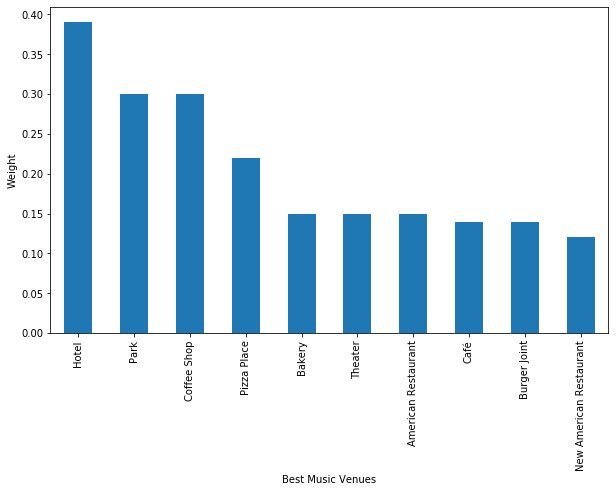

In [51]:
CLUSTER=1
Name="C"+str(CLUSTER)
Name=LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].iloc[:,1:-1].sum(axis=0).to_frame().sort_values(by=[0],ascending = False)
Name.rename(columns = {0:'Weight' }, inplace = True)

Name.iloc[0:10,0].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Best Music Venues')
plt.ylabel('Weight')

print("# of LMV in this cluster {}".format(LMV_venues_onehot_grouped[Final['Cluster']==CLUSTER].shape[0]))

Text(0, 0, 'x')

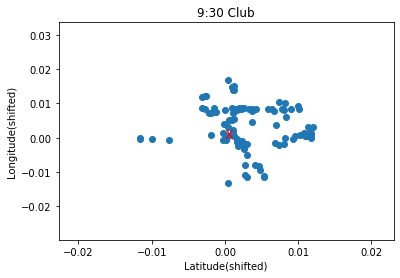

In [36]:
SMV='9:30 Club'
SelecMV=LMV_venues[LMV_venues['Best Music Venue'].str.match(SMV)]
plt.scatter((SelecMV['MV Latitude']-SelecMV['Venue Latitude']),(SelecMV['MV Longitude']-SelecMV['Venue Longitude'])) 
plt.xlabel('Latitude(shifted)')
plt.ylabel('Longitude(shifted)')
plt.title(SMV)
plt.text(0,0,'x',fontsize=15,color='red')

Text(0, 0, 'x')

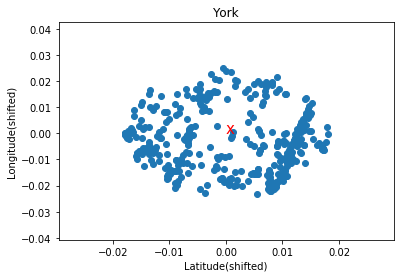

In [38]:
SMV='York'
SelecMV=Total_venues[Total_venues['Name'].str.match(SMV)]
plt.scatter((SelecMV['Latitude']-SelecMV['Venue Latitude']),(SelecMV['Longitude']-SelecMV['Venue Longitude'])) 
plt.xlabel('Latitude(shifted)')
plt.ylabel('Longitude(shifted)')
plt.title(SMV)
plt.text(0,0,'x',fontsize=15,color='red')